In [1]:
#For plotting
import matplotlib.pyplot as plt
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for plotting
import seaborn as sns
sns.set_style("white")
%matplotlib inline

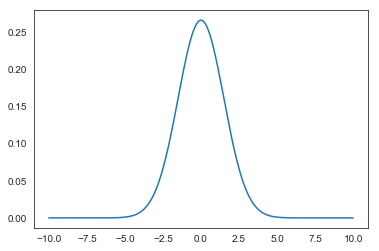

In [2]:
#Return evenly spaced numbers over a specified interval.
x = np.linspace(start=-10, stop=10, num=1000)
#A normal continuous random variable.
#The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation.
y = stats.norm.pdf(x, loc=0, scale=1.5)
#plot it!
plt.plot(x,y)

In [3]:
#for data preprocessing
import pandas as pd

In [8]:
#read our dataset
df = pd.read_csv("bimodal_example.csv")
#show first 5 examples (in BTC)
df.head(n=5)

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


In [9]:
#show the distribution of the data as a histogram
data = df.x

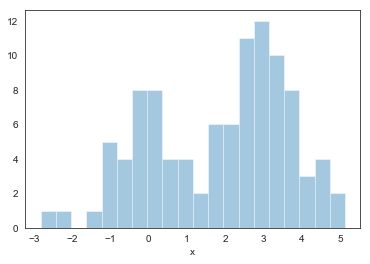

In [10]:
#plot histogram
sns.distplot(data, bins=20, kde=False)

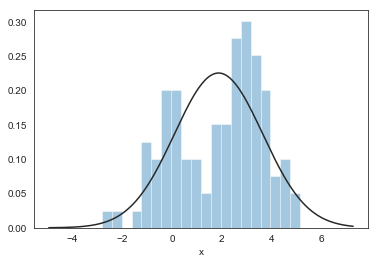

In [11]:
#try to fit a normal distribution to this data
sns.distplot(data, fit=stats.norm, bins=20, kde=False,)

In [12]:
class Gaussian:
    
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma
       
    #probability density function
    def pdf(self, datum):
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    #printing model values
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [14]:
#gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu,best_single.sigma))

Best single Gaussian: μ = 1.9, σ = 1.8


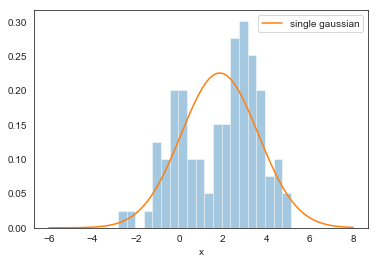

In [17]:
#fit a single gaussian curve to the data
x = np.linspace(-6, 8, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [18]:
from math import sqrt, log, exp, pi
from random import uniform

In [35]:
class GaussianMixture:
    
    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):                                                                    
        self.data = data
        #init with multiple gaussians
        self.loglike = 0.
        self.one = Gaussian(uniform(mu_min, mu_max),
                           uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max),
                           uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix
        
    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield(wp1, wp2)
            
    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                 for (w, d) in zip(left / data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                 for (w, d) in zip(rigt / data)) / one_den)
        # compute new mix
        self.mix = one_den / len(data)
        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
    
    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [38]:
# Check out the fitting process
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        #train!        
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

In [39]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

Computing best model with random restarts...



Done. 🙂


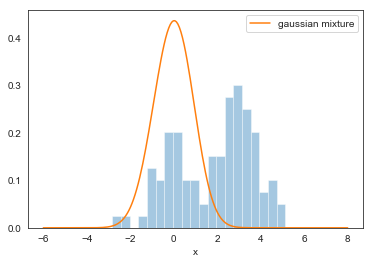

In [40]:
#mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
plt.legend();

